# Imports

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
import pandas as pd

In [2]:
print(tf.__version__)

2.18.0


In [3]:
# Modify GPU memory allocator to try to prevent full GPU memory.
# This can in some cases be counter productive!
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

# Helper Functions

In [4]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [5]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importa Data

In [7]:
DATASET_PATH = "/content/drive/MyDrive/seconds_per_frame0.50,overlap0.25,mfccs40_.csv"
df = pd.read_csv(DATASET_PATH, header=None)                     # No header in your format
dataset = df.iloc[:, :-1].to_numpy(dtype=np.float32)            # All but last column as float16
labels_set = df.iloc[:, -1].to_numpy(dtype=str)                 # Last column as string

In [8]:
INPUT_SHAPE = (40, 16, 1)
dataset = dataset.reshape(dataset.shape[0], INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2])

print(f"Dataset shape: {dataset.shape}")
print(f"Labels shape: {labels_set.shape}")
print(f"Input shape: {INPUT_SHAPE}")

Dataset shape: (583554, 40, 16, 1)
Labels shape: (583554,)
Input shape: (40, 16, 1)


In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(dataset, labels_set, test_size=0.2, random_state=42, stratify=labels_set)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Print the lengths of the training, validation, and testing sets.
print(f"Training set length: {len(x_train)}")
print(f"Validation set length: {len(x_val)}")
print(f"Testing set length: {len(x_test)}")

Training set length: 373474
Validation set length: 93369
Testing set length: 116711


In [10]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights (based on training data).
class_weight = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
dist_class_weight = dict(enumerate(class_weight))

In [11]:
print(f"Classes: {np.unique(labels_set)}")
print(f"Class weights: {dist_class_weight}")

# Print out the amount of each class.
unique, counts = np.unique(y_train, return_counts=True)
print(f"Training class distribution: {dict(zip(unique, counts))}")

Classes: ['Background_noise' 'Car' 'Commercial_vehicles' 'Motorcycle']
Class weights: {0: np.float64(2.8794331709122307), 1: np.float64(1.070813358717343), 2: np.float64(0.5228619268418341), 3: np.float64(1.2402499933583062)}
Training class distribution: {np.str_('Background_noise'): np.int64(32426), np.str_('Car'): np.int64(87194), np.str_('Commercial_vehicles'): np.int64(178572), np.str_('Motorcycle'): np.int64(75282)}


In [12]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Hot end code the labels.
label_encoder = LabelEncoder()
y_train = to_categorical(label_encoder.fit_transform(y_train))
y_test = to_categorical(label_encoder.fit_transform(y_test))
y_val = to_categorical(label_encoder.fit_transform(y_val))

## Model


### Helper Functions

In [13]:
def compileModel(model, learning_rate = 0.001):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['categorical_accuracy']
    )
    model.summary()

In [14]:
# Print training history
# Function used for printing two plots, one for accuracy and one for loss.
# To be used with the history object from the fit method
def printHistory(history):
  # Collect the number of epochs run based on the amount of loss value under history.
  epochs = len(history.history['loss'])

  epochrange = range(1, epochs + 1)
  train_acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.plot(epochrange, train_acc, 'bo', label='Training acc')
  plt.plot(epochrange, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy (modell 1)')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochrange, train_loss, 'bo', label='Training loss')
  plt.plot(epochrange, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss (modell 1)')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

def printConfusionMatrix(model, x_test, y_test, labels_set):
    y_train_int = np.argmax(y_train, axis=1)  # Convert one-hot to integer labels for y_train
    y_test_int = np.argmax(y_test, axis=1)  # Convert one-hot to integer labels for y_test

    y_pred_prob = model.predict(x_test)

    y_pred = np.argmax(y_pred_prob, axis=1)  # Convert softmax probabilities to class indices

    # Ensure that the labels are in 1D arrays (class indices) before passing to confusion_matrix
    print(f"y_train_int shape: {y_train_int.shape}")
    print(f"y_test_int shape: {y_test_int.shape}")
    print(f"y_pred shape: {y_pred.shape}")

    # Define your class labels (ensure they match the number of classes)
    class_names = np.unique(labels_set)  # Assuming labels_set contains class names

    # Generate confusion matrix
    cm = confusion_matrix(y_test_int, y_pred)

    # Visualize the confusion matrix with proper labels
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [16]:
from keras.callbacks import EarlyStopping

# Fit model function used for convinience when fitting the model multiple times
def fitModel(model, x_train, y_train, x_val, y_val, epochs, doPrintHistory, class_weight, verbose, batch_size):

    # Define early stopping callback.
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(
        x=x_train,
        y=y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        verbose=verbose,
        class_weight=class_weight,
        batch_size=batch_size,
        callbacks=[early_stopping],
    )
    # Print history
    if doPrintHistory: printHistory(history)

### Create, train, compile, test

In [17]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

model = keras.Sequential([
    InputLayer(shape=INPUT_SHAPE),

    Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
    MaxPooling2D(),

    Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
    MaxPooling2D(),

    # Feature Pooling (Combining Max & Average Pooling)
    Flatten(),

    # Fully Connected Layer
    Dense(32, activation="relu", kernel_regularizer=l2(0.001)),

    # Output Layer (Softmax for multi-class classification)
    Dense(units=len(np.unique(labels_set))) # Softmax barely increase size.
])

In [18]:
compileModel(model)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 40, 16, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 20, 8, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 20, 8, 32)           │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 4, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          40,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,692 (198.02 KB)

 Trainable params: 50,692 (198.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
11672/11672 ━━━━━━━━━━━━━━━━━━━━ 56s 4ms/step - categorical_accuracy: 0.4841 - loss: 1.0482 - val_categorical_accuracy: 0.4829 - val_loss: 1.0620
Epoch 2/8
11672/11672 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - categorical_accuracy: 0.5272 - loss: 0.8772 - val_categorical_accuracy: 0.5218 - val_loss: 1.0003
Epoch 3/8
11672/11672 ━━━━━━━━━━━━━━━━━━━━ 79s 4ms/step - categorical_accuracy: 0.5319 - loss: 0.8570 - val_categorical_accuracy: 0.5257 - val_loss: 1.0126
Epoch 4/8
11672/11672 ━━━━━━━━━━━━━━━━━━━━ 83s 4ms/step - categorical_accuracy: 0.5308 - loss: 0.8496 - val_categorical_accuracy: 0.5536 - val_loss: 0.9661
Epoch 5/8
11672/11672 ━━━━━━━━━━━━━━━━━━━━ 53s 5ms/step - categorical_accuracy: 0.5386 - loss: 0.8435 - val_categorical_accuracy: 0.5599 - val_loss: 0.9567
Epoch 6/8
11672/11672 ━━━━━━━━━━━━━━━━━━━━ 73s 4ms/step - categorical_accuracy: 0.5429 - loss: 0.8392 - val_categorical_accuracy: 0.5689 - val_loss: 0.9489
Epoch 7/8
11672/11672 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - catego

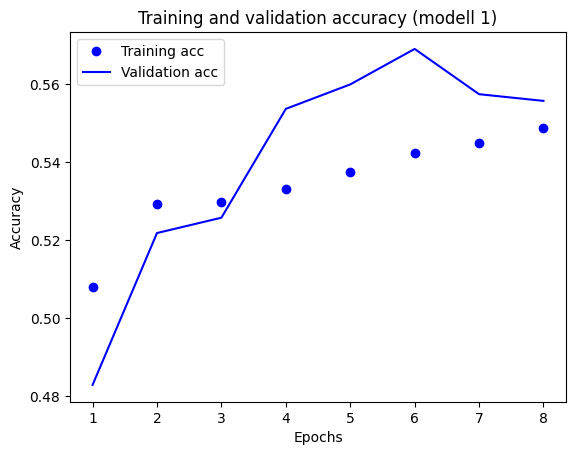

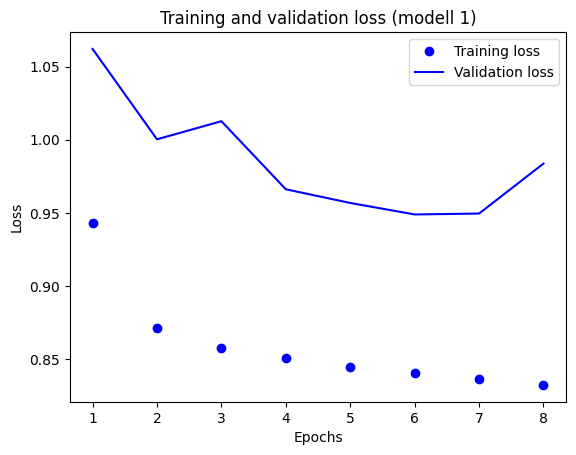

In [19]:
fitModel(model, x_train, y_train, x_val, y_val, 6, True, dist_class_weight, 1, 32)

In [20]:
# Evaluate the model on the test set.
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

3648/3648 - 9s - 2ms/step - categorical_accuracy: 0.5680 - loss: 0.9517
Test accuracy: 0.5679927468299866


3648/3648 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
y_train_int shape: (373474,)
y_test_int shape: (116711,)
y_pred shape: (116711,)


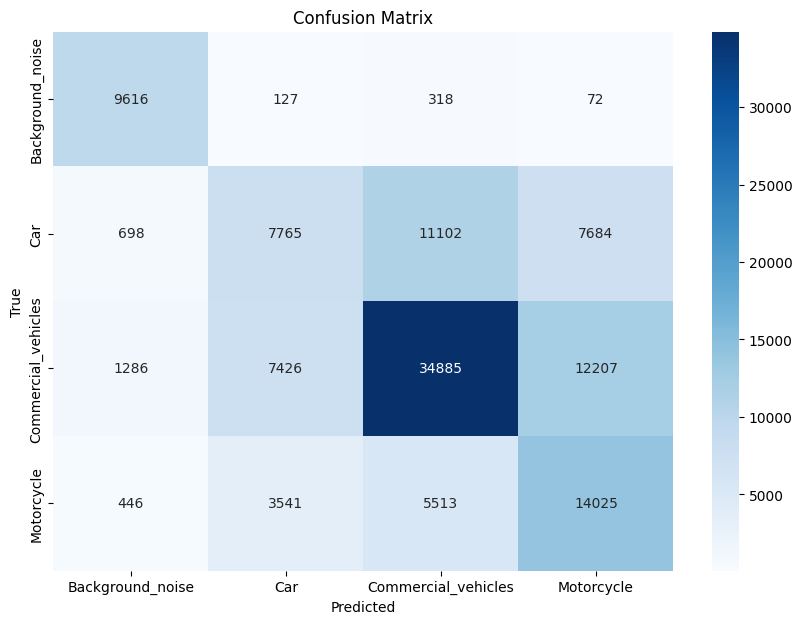

In [73]:
printConfusionMatrix(model, x_test, y_test, labels_set)

# Save & Compress model

### Keras (h5) model

In [81]:
KERAS_MODEL_NAME = "tf_model_mini.h5" # Try using .keras instead.
model.save(KERAS_MODEL_NAME)
convert_bytes(get_file_size(KERAS_MODEL_NAME), "KB")
keras_model_size = get_file_size(KERAS_MODEL_NAME)

File size: 231.484 Kilobytes


### TF Lite model

In [82]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)

#tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
#tf_lite_converter.target_spec.supported_types = [tf.float32]

tflite_model = tf_lite_converter.convert()
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")
tflite_file_size = get_file_size(TF_LITE_MODEL_FILE_NAME)

# Print model input and output shape.
interpreter = tf.lite.Interpreter(model_path=TF_LITE_MODEL_FILE_NAME)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

# Evaluate the model on the test set.
predictions = []
for i in range(len(x_test)):
  # Set the input tensor.
  interpreter.set_tensor(input_details[0]['index'], [x_test[i]])

  # Run inference.
  interpreter.invoke()

  # Get the output tensor.
  output_data = interpreter.get_tensor(output_details[0]['index'])
  predictions.append(output_data)

# Convert predictions to class labels
predicted_labels = [np.argmax(prediction[0]) for prediction in predictions]
true_labels = [np.argmax(label) for label in y_test]

# Calculate accuracy
correct_predictions = sum([1 for true, predicted in zip(true_labels, predicted_labels) if true == predicted])
accuracy = correct_predictions / len(true_labels)

# Print a classification report
print(classification_report(true_labels, predicted_labels))

Saved artifact at '/tmp/tmpj2fvvbzd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 40, 16, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  133985358453200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133985358460304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133985358459536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133985358448400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133985358457808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133985358457232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133985358461072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133985358448208: TensorSpec(shape=(), dtype=tf.resource, name=None)
File size: 201.098 Kilobytes
Input Shape: [ 1 40 16  1]
Input Type: <class 'numpy.float32'>
Output Shape: [1 4]
Output Type: <class 'numpy.float32'>
          

In [83]:
# prompt: Save TF_LITE_MODEL_FILE_NAME as a cpp file using xxd

# ... (Your existing code) ...

TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"

# ... (Your existing code) ...

# Save the TF Lite model as a C++ array using xxd
!xxd -i {TF_LITE_MODEL_FILE_NAME} > tf_lite_model.cpp

# ... (The rest of your code) ...
